In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# k-Armed Bandit Problem

The k-armed bandit problem involves repeatedly choosing among k options (actions), each action produces a reward that is sampled from a stationary probability distribution. The objective is to maximize total reward over a large number of time steps. For this notebook, we will use $k=10$.

Imagine a box with 10 levers, and at each time step you get to pick which lever to pull. Stationary distribution means that the reward distribution for each lever is fixed at creation, and does not change over time. 

## $\epsilon$-Greedy Action Selection Method
One way of selecting the best lever to pull is to look at the past levers that have been pulled, and take the one that has the highest estimate for future reward. 
$$ A_t = argmax_a Q_t(a) $$
- ties amongst actions are broken arbitrarily

Here is how you form the estimate
$$ 
    Q_t(a) = = \frac{\sum_{i=1}^{t-1}R_i\mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
$$

  = sum of rewards with $a$ taken prior to $t$ / #times $a$ has been taken prior to $t$

## The 10-armed bandit testbed
The 10-armed bandit testbed is a set of 2000 10-armed bandit problem. Each bandit represents a reward function for selection action `i`, where `i=1,...,10`. Each problem has 10 bandits, which means that there are 10 such reward functions per problem definition. The way that we store this is through a 2000x10 numpy array, each entry drawn from a N(0,1). Each row represents a problem, and there are 2000 such problems.

In [2]:
testbed = np.random.normal(0, 1, (2000, 10))

In [3]:
testbed

array([[-0.0050734 , -0.83021085, -1.79735128, ..., -0.30077165,
        -1.6250948 ,  0.89934849],
       [-0.24635891,  0.64814   ,  2.16433216, ..., -0.77266119,
         0.07817089,  0.43082919],
       [-1.17358907,  0.29729341,  0.66978224, ..., -1.67777678,
         1.03364988, -1.53127684],
       ...,
       [-1.32959673,  0.37464221, -1.73379318, ..., -0.58009674,
         0.9603404 , -1.47469513],
       [ 0.80671198, -1.02273288, -0.59899614, ...,  0.88977912,
        -0.2709243 ,  0.8108254 ],
       [-2.3277529 ,  0.91869176, -0.68474099, ...,  0.53226045,
        -0.39887174, -0.04305025]])

# Creating a $\epsilon$-Greedy Bandit Agent

The algorithm to update the value estimates is a simple incremental update that take O(1) space and O(1) time per timestep.

In [4]:
class BanditAgent:
    def __init__(self, eps=0, num_bandits=10):
        self._eps=eps
        self._num_bandits=num_bandits
        self._estimates=np.zeros(num_bandits)
        self._frequencies=np.zeros(num_bandits)
        self._total_reward=0

    def select_action(self):
        roll = np.random.uniform()
        if (roll < self._eps):
            # non-greedy case
            return np.random.randint(0, self._num_bandits)
        else:
            return np.argmax(self._estimates)

    def update_estimate(self, action, reward):
        # N(A) = N(A) + 1
        self._frequencies[action]+=1
        # Q(A) = Q(A) + (1/N(A)) * (R - Q(A))
        self._estimates[action] = self._estimates[action] + (1/self._frequencies[action])*(reward - self._estimates[action])
        self._total_reward += reward


In [5]:
def run_testbed(epsilon):
    rewards = np.zeros((2000,1000))
    actions = np.zeros((2000,1000))
    
    for problem in range(2000):
        bandit = BanditAgent(epsilon)
        optimal_action = np.argmax(testbed[problem])
        
        for time in range(1000):
            action = bandit.select_action()
            reward = np.random.normal(testbed[problem][action])
            bandit.update_estimate(action, reward)
            
            rewards[problem][time] = reward
            actions[problem][time] = (action == optimal_action)
    
    average_reward = rewards.mean(axis=0)
    average_optimal = actions.mean(axis=0)
    return average_reward, average_optimal
    

In [6]:
%%time
data = pd.DataFrame(columns=["Average Reward", "% Optimal"], index=pd.Index(data=[0,0.01,0.1], name="Epsilon"))
for eps in data.index:
    average_reward, percent_optimal = run_testbed(eps)
    data.loc[eps] = [average_reward, percent_optimal]

CPU times: user 19.3 s, sys: 2.75 ms, total: 19.3 s
Wall time: 19.3 s


In [7]:
data

,Average Reward,% Optimal
Epsilon,,
0.00,"[-0.044451186430451144, 0.26874778271412086, 0...","[0.0905, 0.14, 0.1815, 0.2065, 0.232, 0.2505, ..."
0.01,"[0.00021642643787953618, 0.23852615749863829, ...","[0.0925, 0.1415, 0.1745, 0.2045, 0.226, 0.241,..."
0.10,"[-0.02280423751401293, 0.2719877296965513, 0.3...","[0.0935, 0.146, 0.1715, 0.1805, 0.2095, 0.2285..."


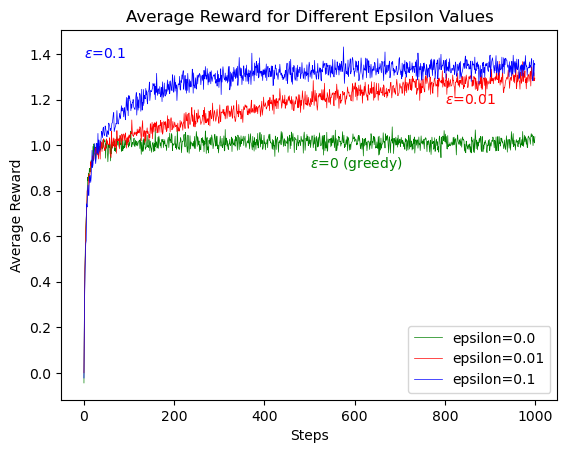

In [8]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data.index, colors):
    plt.plot(data.loc[idx]['Average Reward'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
plt.text(0, 1.4, f'$\epsilon$={0.1}', 
         color='blue', fontsize=10, verticalalignment='center')

plt.text(800, 1.2, f'$\epsilon$={0.01}', 
         color='red', fontsize=10, verticalalignment='center')

plt.text(500, 0.92, f'$\epsilon$={0} (greedy)', 
         color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Epsilon Values')
plt.legend()

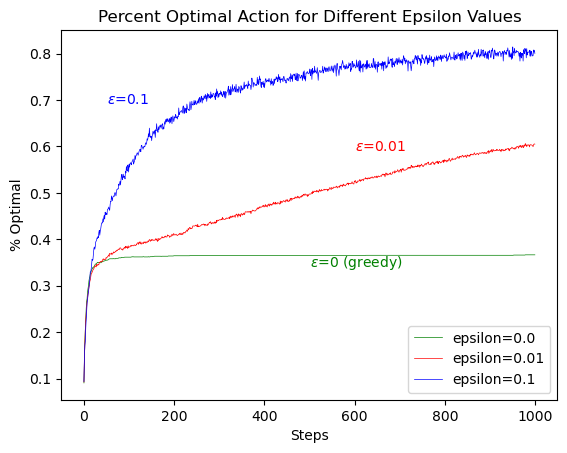

In [9]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data.index, colors):
    plt.plot(data.loc[idx]['% Optimal'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
plt.text(50, 0.7, f'$\epsilon$={0.1}', 
         color='blue', fontsize=10, verticalalignment='center')

plt.text(600, 0.6, f'$\epsilon$={0.01}', 
         color='red', fontsize=10, verticalalignment='center')

plt.text(500, 0.35, f'$\epsilon$={0} (greedy)', 
         color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('% Optimal')
plt.title('Percent Optimal Action for Different Epsilon Values')
plt.legend()

## What would happen if reward distributions were non-stationary?

In order to demonstrate how sample-average methods have trouble with non-stationary problems, we will start with all the $q_*(a) = 0$, and on each time step take independent random walks by adding a normally distributed increment sampled from $N(0,std=0.01)$. 

Instead of generating all the $q_*(a)$ for all 2000 problems at once, we will generate the random walks one at a time. Each problem will start with $q_*(a)=0$ for all $a$. Note that because of the non-stationary nature of the rewards, the optimal action could change at each step. 

In [10]:
problem = np.zeros(10)
problem

random_walk = np.random.normal(0,0.01, 10)
random_walk



array([ 0.0173712 , -0.0148713 ,  0.01661272,  0.00505872,  0.00568847,
        0.00048684, -0.00899684,  0.00161078,  0.00054728, -0.00555089])

In [11]:
problem += random_walk
problem

array([ 0.0173712 , -0.0148713 ,  0.01661272,  0.00505872,  0.00568847,
        0.00048684, -0.00899684,  0.00161078,  0.00054728, -0.00555089])

In [12]:
def run_testbed_non_stationary(epsilon):
    np.random.seed(0)
    rewards = np.zeros((2000,1000))
    actions = np.zeros((2000,1000))
    
    for i in range(2000):
        bandit = BanditAgent(epsilon)
        problem = np.zeros(10)
        
        for time in range(1000):
            problem += np.random.normal(0,0.01,10)
            optimal_action = np.argmax(problem)

            action = bandit.select_action()
            reward = np.random.normal(problem[action])
            bandit.update_estimate(action, reward)
            
            rewards[i][time] = reward
            actions[i][time] = (action == optimal_action)
    
    average_reward = rewards.mean(axis=0)
    average_optimal = actions.mean(axis=0)
    return average_reward, average_optimal
    

In [13]:
%%time
data_ns = pd.DataFrame(columns=["Average Reward", "% Optimal"], index=pd.Index(data=[0,0.01,0.1], name="Epsilon"))
for eps in data_ns.index:
    average_reward, percent_optimal = run_testbed(eps)
    data_ns.loc[eps] = [average_reward, percent_optimal]

CPU times: user 19.6 s, sys: 2.95 ms, total: 19.7 s
Wall time: 19.7 s


In [14]:
data_ns

,Average Reward,% Optimal
Epsilon,,
0.00,"[-0.020555941426447195, 0.27795484055394454, 0...","[0.0905, 0.137, 0.17, 0.1935, 0.217, 0.2425, 0..."
0.01,"[-0.007841667593652029, 0.27467354613506995, 0...","[0.0915, 0.14, 0.175, 0.195, 0.2215, 0.2435, 0..."
0.10,"[-0.044809037494575044, 0.25909206191310247, 0...","[0.094, 0.139, 0.1715, 0.1945, 0.2055, 0.2315,..."


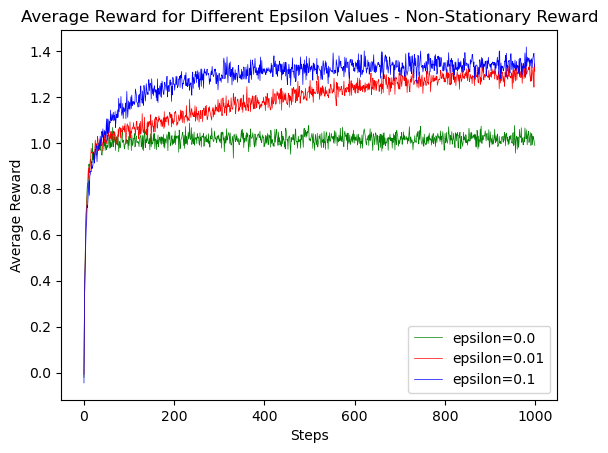

In [15]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data_ns.index, colors):
    plt.plot(data_ns.loc[idx]['Average Reward'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
# plt.text(0, 1.4, f'$\epsilon$={0.1}', 
#          color='blue', fontsize=10, verticalalignment='center')

# plt.text(800, 1.2, f'$\epsilon$={0.01}', 
#          color='red', fontsize=10, verticalalignment='center')

# plt.text(500, 0.92, f'$\epsilon$={0} (greedy)', 
#          color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Epsilon Values - Non-Stationary Reward')
plt.legend()

Wow that's a huge different from the stationary one! Some things that stand out:
- The average reward is significantly lower when reward is non-stationary - Stationary case is finds reward 1.0-1.4, and exploits constantly. In non-stationary case, reward is not much higher than 0.30.
- Lack of convergence in average reward over time. Since the rewards themselves are moving, this is expected.
- Higher noise in average rewards, again since the rewards themselves are moving, this is expected.
- A positive trend, and a stronger positive trend in higher epsilon (higher probability of non-greedy action selection). Since rewards are moving, the higher forced exploration means the agent is trying new actions more actions, and receiving updated samples from the new distributions. Since the random walks are also normally distributed with a small std, rewards that get higher tend to stay higher, so the value-estimates are somewhat valid.

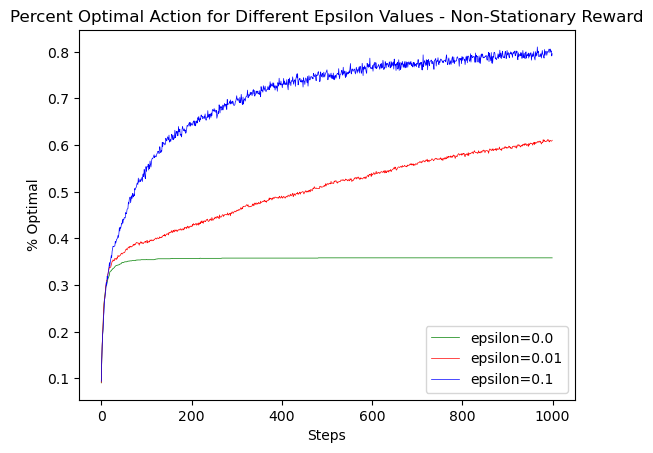

In [16]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data_ns.index, colors):
    plt.plot(data_ns.loc[idx]['% Optimal'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
# plt.text(50, 0.7, f'$\epsilon$={0.1}', 
#          color='blue', fontsize=10, verticalalignment='center')

# plt.text(600, 0.6, f'$\epsilon$={0.01}', 
#          color='red', fontsize=10, verticalalignment='center')

# plt.text(500, 0.35, f'$\epsilon$={0} (greedy)', 
#          color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('% Optimal')
plt.title('Percent Optimal Action for Different Epsilon Values - Non-Stationary Reward')
plt.legend()

A stark difference again from the stationary case:
- No convergence to the optimal action. Even in the eps=0.1 case, at peak we're seeing 35% optimal action vs 80%+ in the stationary case (in fact, this should converge to 91%).
- % Optimal action is much higher with higher epsilon, as expected. Since the optiaml action is changing over time due to the random walks, any agent that picks the same policy until it gets bad is going to fare worse than one that is exploring more often.  